In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from scipy.integrate import quad

from psiam_tied_no_dv_map_utils import cum_A_t_fn

# read csv and get necessary sesion type, non repeated, 16 trainlevel

In [5]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ].copy()

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# ABL and ILD

In [6]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [8]:
animal_wise_led_on_samples = {}
animal_wise_led_off_samples = {}

for animal in df['animal'].unique():
    animal_wise_led_on_samples[animal] = {}
    animal_wise_led_off_samples[animal] = {}


# Trunc 

In [9]:
T_trunc = 0.3


# pdf calc functions for aborts

In [10]:
def rho_A_t_fn(t, V_A, theta_A, NDT):
    """
    For AI,prob density of t given V_A, theta_A
    """
    t -= NDT
    if t < 0:
        return 0
    rho = (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))
    return rho

def stim_surive_fn(t):
    """
    Prob that stim survives till time t =  1 - CDF(P_stim)
    """
    if t < 0.2:
        return 1
    p_stim_surive = np.exp(- (t - 0.2)/0.4)
    return p_stim_surive

def rho_A_t_and_stim_survive(t, V_A, theta_A, NDT):
    """
    prob that AI hit and stim survive till time t
    """
    return rho_A_t_fn(t, V_A, theta_A, NDT)*stim_surive_fn(t)

def rho_A_t_and_stim_survive_truncated(t, V_A, theta_A, NDT, pdf_trunc_factor):
    """
    prob that AI hit and stim survive, but truncated at T_trunc. 
    """
    if t < T_trunc:
        return 0
    return rho_A_t_and_stim_survive(t, V_A, theta_A, NDT)*pdf_trunc_factor

def area_for_rho_A_t_stim_survive_trunc_0_to_inf(V_A, theta_A, NDT, pdf_factor):
    """
    Area under the curve of rho_A_t_and_stim_survive_truncated from 0 to inf
    """
    area = quad(rho_A_t_and_stim_survive_truncated, 0, np.inf, args=(V_A, theta_A, NDT, pdf_factor))[0]
    return area

def pdf_trunc_factor_for_stim_surive_trunc(V_A, theta_A, NDT):
    """
    Factor to normalize the truncated pdf
    """
    return 1/(1 - quad(rho_A_t_and_stim_survive, 0, T_trunc, args=(V_A, theta_A, NDT))[0])

def rho_A_t_stim_survive_truncated_and_norm(t, V_A, theta_A, NDT, area, pdf_factor):
    """
    prob that AI hit and stim surive but truncated and ALSO normalized
    """
    return rho_A_t_and_stim_survive_truncated(t, V_A, theta_A, NDT, pdf_factor)/area


# bounds,  prior fn, loglike

In [ ]:
V_A_bounds = [0.01, 5]
theta_A_bounds = [0.01, 5]
NDT_bounds = [0.01, 0.5]

V_A_plausible_bounds = [0.5,3] 
theta_A_plausible_bounds = [0.5,3]
NDT_plausible_bounds = [0.03, 0.2]

def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A, theta_A, NDT = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    NDT_logpdf = trapezoidal_logpdf(NDT, NDT_bounds[0], NDT_plausible_bounds[0], NDT_plausible_bounds[1], NDT_bounds[1])

    return V_A_logpdf + theta_A_logpdf + NDT_logpdf

def compute_loglike(t, V_A, theta_A, NDT, area, pdf_factor):
    likelihood = rho_A_t_stim_survive_truncated_and_norm(t, V_A, theta_A, NDT, area, pdf_factor)

    
    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


# vbmc init

In [13]:
lb = [V_A_bounds[0], theta_A_bounds[0], NDT_bounds[0]]
ub = [V_A_bounds[1], theta_A_bounds[1], NDT_bounds[1]]


plb = [V_A_plausible_bounds[0], theta_A_plausible_bounds[0], NDT_plausible_bounds[0]]
pub = [V_A_plausible_bounds[1], theta_A_plausible_bounds[1], NDT_plausible_bounds[1]]

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
NDT_0 = np.random.uniform(NDT_plausible_bounds[0], NDT_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, NDT_0])


# vbmc for each animal

In [16]:
all_animals = df['animal'].unique()

## LED on

In [39]:
# FOR LED ON
for animal in all_animals[1:]:

    animal_df = df[ df['animal'].isin([animal]) ]

    animal_led_on_trials = animal_df[ animal_df['LED_trial'] == 1 ]

    abort_animal_led_on_trials = animal_led_on_trials[ (animal_led_on_trials['abort_event'] == 3) \
                                                      & (animal_led_on_trials['timed_fix'] > animal_led_on_trials['LED_onset_time']) ]
    



    abort_RT = abort_animal_led_on_trials['timed_fix'].values
    

    def vbmc_loglike_abort_fn(params):
        V_A, theta_A, NDT = params

        pdf_factor = pdf_trunc_factor_for_stim_surive_trunc(V_A, theta_A, NDT)
        area = area_for_rho_A_t_stim_survive_trunc_0_to_inf(V_A, theta_A, NDT, pdf_factor)

        # because there are less aborts, single job runs faster
        all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(t, V_A, theta_A, NDT, area, pdf_factor)\
                                        for t in abort_RT if t > T_trunc)

        loglike = np.sum(all_loglike)
        return loglike

    def vbmc_prior_plus_loglike_fn(params):
        return vbmc_loglike_abort_fn(params) + vbmc_prior_abort_fn(params)
    
    vbmc = VBMC(vbmc_prior_plus_loglike_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
    vp, results = vbmc.optimize()

    vp_samples = vp.sample(int(1e5))[0]

    vp.save(f'vbmc_aborts_animal_wise_{animal}_led_on_samples.pkl')
    animal_wise_led_on_samples[animal] = vp_samples

        

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -34.881 +/-0.007.
Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -75.342 +/-0.006.
Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 29.124 +/-0.002.
Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3

# IS led on fit aborts good?

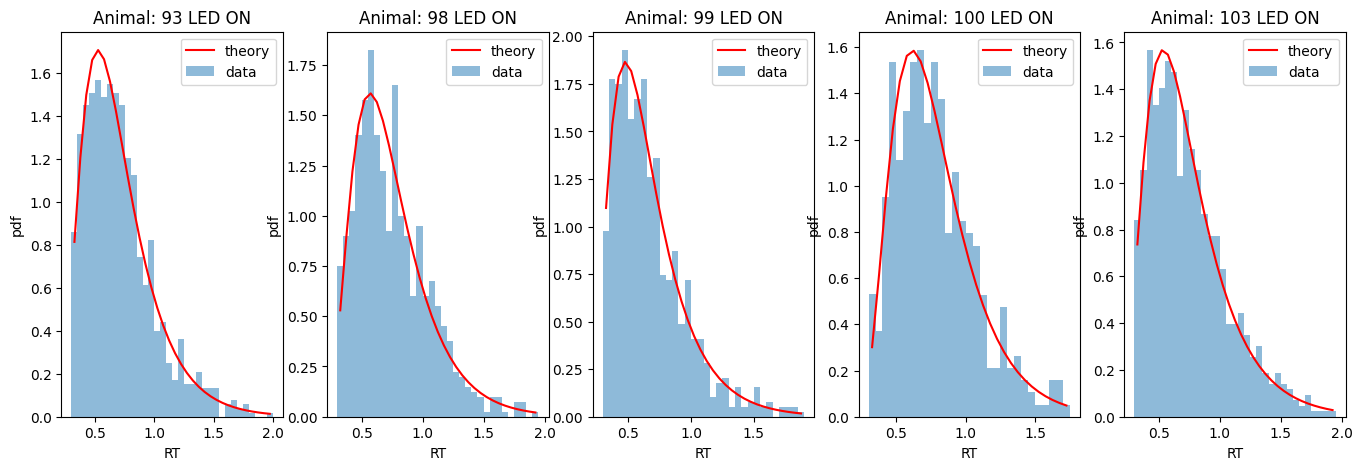

In [53]:

a = 1
plt.figure(figsize=(20,5))
for animal in all_animals[1:]:

    animal_df = df[ df['animal'].isin([animal]) ]

    animal_led_on_trials = animal_df[ animal_df['LED_trial'] == 1 ]

    abort_animal_led_on_trials = animal_led_on_trials[ (animal_led_on_trials['abort_event'] == 3) \
                                                      & (animal_led_on_trials['timed_fix'] > animal_led_on_trials['LED_onset_time']) ]
    



    abort_RT = abort_animal_led_on_trials['timed_fix'].values
    abort_rt_trunc = abort_RT[ abort_RT > T_trunc]

    bin_width = 0.05
    bins = np.arange(T_trunc, np.max(abort_rt_trunc) + bin_width, bin_width)
    hist, _ = np.histogram(abort_rt_trunc, bins=bins, density=True)

    t_pts = bins[:-1] + bin_width/2
    V_A_mean = animal_wise_led_on_samples[animal][:,0].mean()
    theta_A_mean = animal_wise_led_on_samples[animal][:,1].mean()
    NDT_mean = animal_wise_led_on_samples[animal][:,2].mean()

    pdf_factor = pdf_trunc_factor_for_stim_surive_trunc(V_A_mean, theta_A_mean, NDT_mean)
    area = area_for_rho_A_t_stim_survive_trunc_0_to_inf(V_A_mean, theta_A_mean, NDT_mean, pdf_factor)
    theory_pdf = np.array([rho_A_t_stim_survive_truncated_and_norm(t, V_A_mean, theta_A_mean, NDT_mean, area, pdf_factor) for t in t_pts])

    plt.subplot(1,len(all_animals),a)
    plt.bar(bins[:-1], hist, width=bin_width, align='edge', alpha=0.5, label='data')
    plt.plot(t_pts, theory_pdf, color='red', label='theory')
    plt.legend()
    plt.xlabel('RT'); plt.ylabel('pdf'); plt.title(f'Animal: {animal} LED ON')

    a += 1

# LED off

In [54]:
# FOR LED OFF
for animal in all_animals:

    animal_df = df[ df['animal'].isin([animal]) ]

    animal_led_off_trials = animal_df[ animal_df['LED_trial'] == 0 ]

    abort_animal_led_off_trials = animal_led_off_trials[ (animal_led_off_trials['abort_event'] == 3)  ]
                                                      
    



    abort_RT = abort_animal_led_off_trials['timed_fix'].values
    

    def vbmc_loglike_abort_fn(params):
        V_A, theta_A, NDT = params

        pdf_factor = pdf_trunc_factor_for_stim_surive_trunc(V_A, theta_A, NDT)
        area = area_for_rho_A_t_stim_survive_trunc_0_to_inf(V_A, theta_A, NDT, pdf_factor)

        # because there are less aborts, single job runs faster
        all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(t, V_A, theta_A, NDT, area, pdf_factor)\
                                        for t in abort_RT if t > T_trunc)

        loglike = np.sum(all_loglike)
        return loglike

    def vbmc_prior_plus_loglike_fn(params):
        return vbmc_loglike_abort_fn(params) + vbmc_prior_abort_fn(params)
    
    vbmc = VBMC(vbmc_prior_plus_loglike_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
    vp, results = vbmc.optimize()

    vp_samples = vp.sample(int(1e5))[0]

    vp.save(f'vbmc_aborts_animal_wise_{animal}_led_off_samples.pkl')
    animal_wise_led_off_samples[animal] = vp_samples

        

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -361.684 +/-0.004.
Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -19.399 +/-0.003.
Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -110.109 +/-0.004.
Reshaping x0 to row vector.
Reshaping lower bounds to (1

# Is LED off fit aborts good?

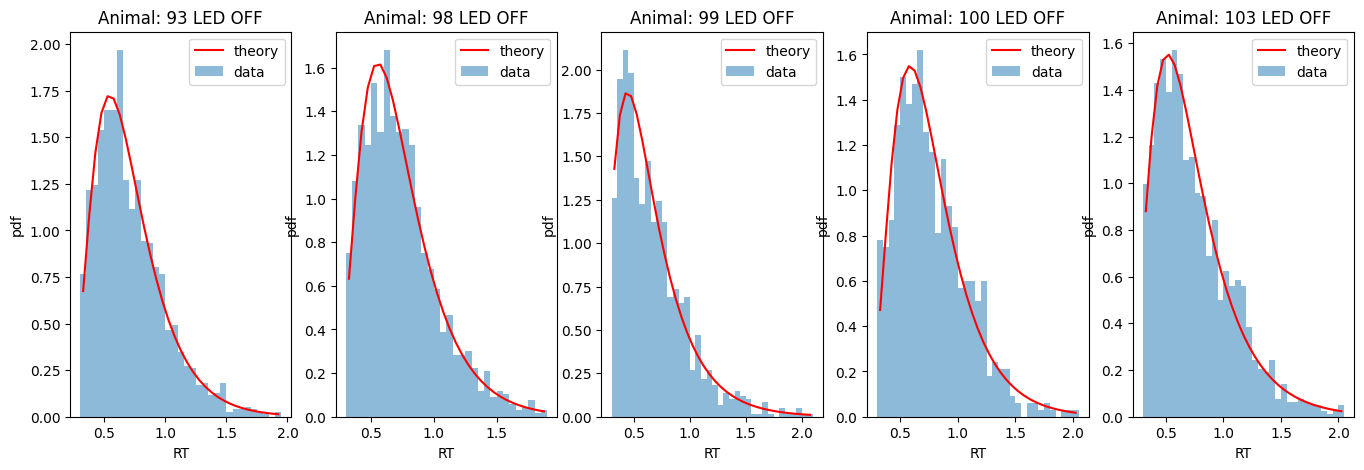

In [56]:
a = 1
plt.figure(figsize=(20,5))
for animal in all_animals[1:]:

    animal_df = df[ df['animal'].isin([animal]) ]

    animal_led_off_trials = animal_df[ animal_df['LED_trial'] == 0 ]

    abort_animal_led_off_trials = animal_led_off_trials[ (animal_led_off_trials['abort_event'] == 3)  ]
                                                      
    



    abort_RT = abort_animal_led_off_trials['timed_fix'].values
    abort_rt_trunc = abort_RT[ abort_RT > T_trunc]

    bin_width = 0.05
    bins = np.arange(T_trunc, np.max(abort_rt_trunc) + bin_width, bin_width)
    hist, _ = np.histogram(abort_rt_trunc, bins=bins, density=True)

    t_pts = bins[:-1] + bin_width/2
    V_A_mean = animal_wise_led_off_samples[animal][:,0].mean()
    theta_A_mean = animal_wise_led_off_samples[animal][:,1].mean()
    NDT_mean = animal_wise_led_off_samples[animal][:,2].mean()

    pdf_factor = pdf_trunc_factor_for_stim_surive_trunc(V_A_mean, theta_A_mean, NDT_mean)
    area = area_for_rho_A_t_stim_survive_trunc_0_to_inf(V_A_mean, theta_A_mean, NDT_mean, pdf_factor)
    theory_pdf = np.array([rho_A_t_stim_survive_truncated_and_norm(t, V_A_mean, theta_A_mean, NDT_mean, area, pdf_factor) for t in t_pts])

    plt.subplot(1,len(all_animals),a)
    plt.bar(bins[:-1], hist, width=bin_width, align='edge', alpha=0.5, label='data')
    plt.plot(t_pts, theory_pdf, color='red', label='theory')
    plt.legend()
    plt.xlabel('RT'); plt.ylabel('pdf'); plt.title(f'Animal: {animal} LED OFF')

    a += 1

# Compare all params

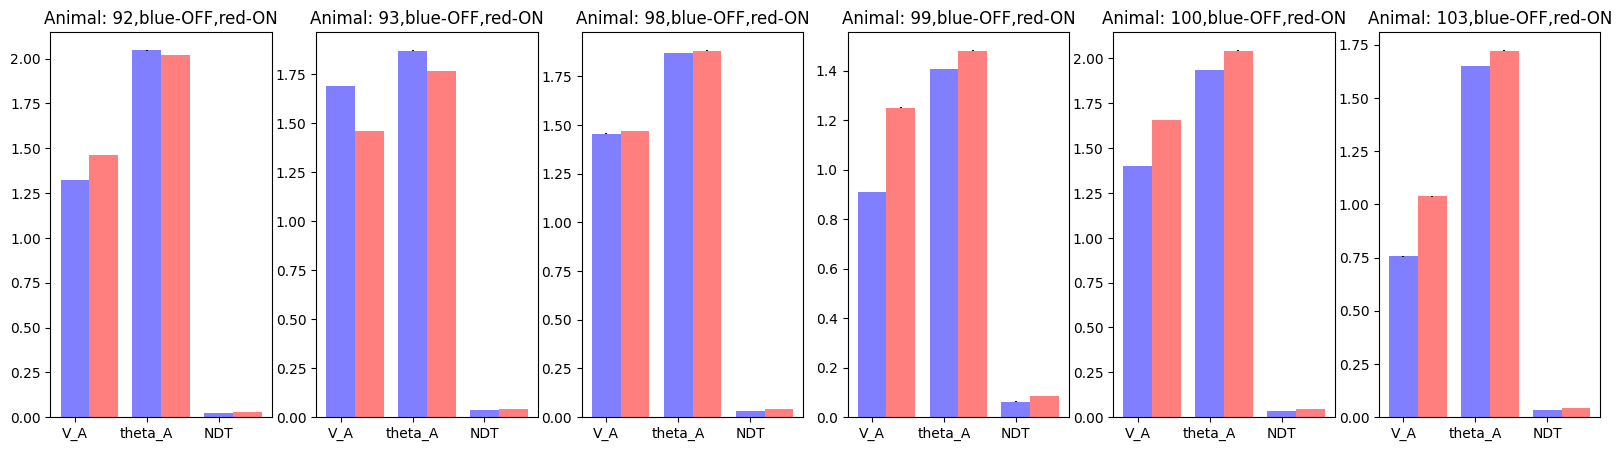

In [63]:
# animal_wise_led_off_samples
# animal_wise_led_on_samples

params = ['V_A', 'theta_A', 'NDT']
plt.figure(figsize=(20,5))
a = 1
for animal in all_animals:
    # on
    V_A_on_mean = animal_wise_led_on_samples[animal][:,0].mean()
    V_A_on_err = animal_wise_led_on_samples[animal][:,0].std()/np.sqrt(len(animal_wise_led_on_samples[animal][:,0]))

    theta_A_on_mean = animal_wise_led_on_samples[animal][:,1].mean()
    theta_A_on_err = animal_wise_led_on_samples[animal][:,1].std()/np.sqrt(len(animal_wise_led_on_samples[animal][:,1]))

    NDT_on_mean = animal_wise_led_on_samples[animal][:,2].mean()
    NDT_on_err = animal_wise_led_on_samples[animal][:,2].std()/np.sqrt(len(animal_wise_led_on_samples[animal][:,2]))

    # off
    V_A_off_mean = animal_wise_led_off_samples[animal][:,0].mean()
    V_A_off_err = animal_wise_led_off_samples[animal][:,0].std()/np.sqrt(len(animal_wise_led_off_samples[animal][:,0]))

    theta_A_off_mean = animal_wise_led_off_samples[animal][:,1].mean()
    theta_A_off_err = animal_wise_led_off_samples[animal][:,1].std()/np.sqrt(len(animal_wise_led_off_samples[animal][:,1]))

    NDT_off_mean = animal_wise_led_off_samples[animal][:,2].mean()
    NDT_off_err = animal_wise_led_off_samples[animal][:,2].std()/np.sqrt(len(animal_wise_led_off_samples[animal][:,2]))

    plt.subplot(1,len(all_animals),a)
    plt.bar([1, 2, 3], [V_A_off_mean, theta_A_off_mean, NDT_off_mean], yerr=[V_A_off_err, theta_A_off_err, NDT_off_err], width=0.4, label='LED OFF', color='b', align='center', alpha=0.5)
    plt.bar([1.4, 2.4, 3.4], [V_A_on_mean, theta_A_on_mean, NDT_on_mean], yerr=[V_A_on_err, theta_A_on_err, NDT_on_err], width=0.4, label='LED ON', color='r', align='center', alpha=0.5)
    plt.xticks([1,2,3], params)
    # plt.legend()
    plt.title(f'Animal: {animal},blue-OFF,red-ON')
    a += 1

